# Note on sources:

## My work was largely influenced by three sources:
1.  Pytorch's Tutorial for Transfer Learning here:
    https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#load-data
2.  Josh Bernard's Medium post on Deep Learning with PyTorch here:
    https://medium.com/@josh_2774/deep-learning-with-pytorch-9574e74d17ad
3.  Pytorch's Tutorial for Saving and Loading models here:
    https://pytorch.org/tutorials/beginner/saving_loading_models.html

### The first two sources being more important than the third.  Additionally, I used ideas from prior Udacity lessons as well.


# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, I'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application.  I'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

When this project is completed, I'll have an application that can be trained on any set of labeled images. Here my network will be learning about flowers and end up as a command line application (see train.py and predict.py).

First up is importing the packages I'll need.

Please make sure if you are running this notebook in the workspace that you have chosen GPU rather than CPU mode.

In [1]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
import json

import torch
from torchvision import datasets, transforms, models
from torch import nn
from torch import optim
from collections import OrderedDict
from torch.autograd import Variable
from torch.optim import lr_scheduler

import helper
from PIL import Image
import time
import copy
import seaborn as seaborn

## Load the data

Here I'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data can be [downloaded here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, I'll apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. I'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this I don't want any scaling or rotation transformations, but I'll need to resize then crop the images to the appropriate size.

The pre-trained networks I'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets I'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

dirs = {'train' : train_dir,
        'valid' : valid_dir,
        'test' : test_dir}

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

In [4]:
# TODO: Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(dirs[x],
transform = data_transforms[x]) for x in ['train', 'valid', 'test']}

# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
batch_size = 32, shuffle = True) for x in ['train', 'valid', 'test']}

dataset_sizes = {x: len(image_datasets[x])
                for x in ['train', 'valid', 'test']}

class_names = image_datasets['train'].classes

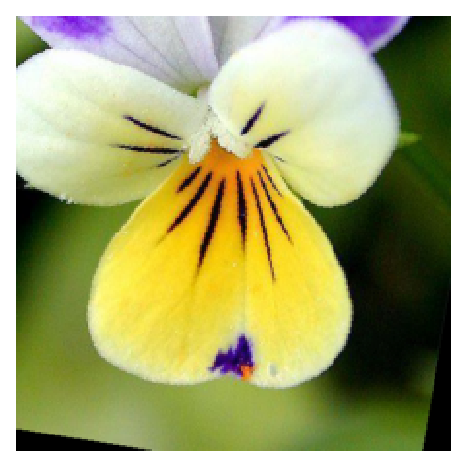

In [5]:
#Test data loader
images, labels = next(iter(dataloaders['train']))
helper.imshow(images[0], normalize=True);

### Label mapping

I'll also need to load in a mapping from category label to category name. I load in the file `cat_to_name.json`. It's a JSON object which I can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give me a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [6]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. I use one of the pretrained models from `torchvision.models` to get the image features. I build and train a new feed-forward classifier using those features.

Things I'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

# I import the VGG16 pre-trained model

In [7]:
model = models.vgg16(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:09<00:00, 57536383.27it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

## I define my classifier and append it to the end of VGG16

In [8]:
classifier = nn.Sequential(OrderedDict([
                                ('fc1', nn.Linear(25088, 3136)),
                                ('relu', nn.ReLU()),
                                ('fc2', nn.Linear(3136, 392)),
                                ('relu', nn.ReLU()),
                                ('fc3', nn.Linear(392, 102)),
                                ('relu', nn.ReLU()),
                                ('output', nn.LogSoftmax(dim=1))
]))

for param in model.parameters():
    param.requires_grad = False

In [9]:
model.classifier = classifier
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

### I tell PyTorch to use cuda if available

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device)

In [11]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

## I define how to train my model

In [12]:
def train_model(model, criteria, optimizer, scheduler,    
                                      num_epochs=10, device='cuda'):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs =inputs.float()
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criteria(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## I define my inputs

In [13]:
criteria = nn.NLLLoss()

# Observe that all parameters are being optimized
optim = optim.Adam(model.classifier.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 4 epochs
sched = lr_scheduler.StepLR(optim, step_size=4, gamma=0.1)

# Number of epochs
eps=10

### I train my model

In [14]:
model_trained = train_model(model, criteria, optim, sched, eps, 'cuda')

Epoch 0/9
----------
train Loss: 2.3650 Acc: 0.4441
valid Loss: 1.0002 Acc: 0.7262

Epoch 1/9
----------
train Loss: 1.2453 Acc: 0.6644
valid Loss: 0.9111 Acc: 0.7689

Epoch 2/9
----------
train Loss: 1.0656 Acc: 0.7108
valid Loss: 0.6996 Acc: 0.8130

Epoch 3/9
----------
train Loss: 1.0204 Acc: 0.7294
valid Loss: 0.5956 Acc: 0.8411

Epoch 4/9
----------
train Loss: 0.6980 Acc: 0.8129
valid Loss: 0.4146 Acc: 0.8863

Epoch 5/9
----------
train Loss: 0.5907 Acc: 0.8382
valid Loss: 0.3961 Acc: 0.8924

Epoch 6/9
----------
train Loss: 0.5771 Acc: 0.8463
valid Loss: 0.3734 Acc: 0.9095

Epoch 7/9
----------
train Loss: 0.5128 Acc: 0.8588
valid Loss: 0.3746 Acc: 0.9071

Epoch 8/9
----------
train Loss: 0.5218 Acc: 0.8544
valid Loss: 0.3654 Acc: 0.9095

Epoch 9/9
----------
train Loss: 0.4913 Acc: 0.8626
valid Loss: 0.3617 Acc: 0.9108

Training complete in 32m 36s
Best val Acc: 0.910758


## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. I run the test images through the network and measure the accuracy, the same way I did validation. I should be able to reach around 70% accuracy on the test set if the model has been trained well.

### I define an accuracy function for evaluation of the model

In [15]:
# TODO: Do validation on the test set

def calc_accuracy(model, data, cuda=False):
    model.eval()
    model.to(device='cuda')    
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(dataloaders[data]):
            if cuda:
                inputs, labels = inputs.cuda(), labels.cuda()
            
            # get model outputs
            
            outputs = model.forward(inputs)
            
            # convert outputs to predictions
            _, predicted = outputs.max(dim=1)
            
            if idx == 0:
                print(predicted) # class
                print(torch.exp(_)) # probability
            equals = predicted == labels.data
            if idx == 0:
                print(equals)
            print(equals.float().mean())

In [16]:
calc_accuracy(model, 'test', True)

tensor([ 95,  53,  98,  31,  80,  11,  33,  74,  96,  75,  34,  73,
         43,  30,  40,  24,  41,  49,  11,  90,  26,   8,  63,  89,
         90,  50,  18,  80,  53,  72,   5,  26], device='cuda:0')
tensor([ 0.5382,  1.0000,  0.9958,  1.0000,  1.0000,  1.0000,  0.9994,
         1.0000,  0.9999,  0.6180,  0.9999,  1.0000,  0.9999,  0.9046,
         0.9511,  1.0000,  1.0000,  0.6173,  1.0000,  0.9997,  0.6568,
         0.9992,  0.9939,  0.6041,  0.9999,  0.5323,  1.0000,  1.0000,
         0.9757,  0.9925,  0.9762,  0.8337], device='cuda:0')
tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1], dtype=torch.uint8, device='cuda:0')
tensor(0.9688, device='cuda:0')
tensor(0.9688, device='cuda:0')
tensor(0.9062, device='cuda:0')
tensor(0.8125, device='cuda:0')
tensor(0.9375, device='cuda:0')
tensor(0.9062, device='cuda:0')
tensor(0.9375, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(

# I get a good model with test accuracy of roughly 89%

## Save the checkpoint

Now that my network is trained, I save the model so I can load it later for making predictions. I want to save other things such as the mapping of classes to indices which I get from one of the image datasets: `image_datasets['train'].class_to_idx`. I can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that I'll want to completely rebuild the model later so I can use it for inference. I make sure to include any information I need in the checkpoint. If I want to load the model and keep training, I'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. I'll likely want to use this trained model in the next part of the project, so best to save it now.

In [17]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  

In [18]:
# TODO: Save the checkpoint 
model.class_to_idx = image_datasets['train'].class_to_idx
model.cpu()
torch.save({'arch': 'vgg16',
            'state_dict': model.state_dict(), 
            'class_to_idx': model.class_to_idx}, 
            'flower_classifier_3.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way I can come back to this project and keep working on it without having to retrain the network.

# Define how to load the checkpoint

In [7]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

def load_model(checkpoint_path):
    chpt = torch.load(checkpoint_path)
    
    if chpt['arch'] == 'vgg16':
        model = models.vgg16(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
    elif chpt['arch'] != 'vgg16':
        print("Must choose vgg16 architecture")

    
    model.class_to_idx = chpt['class_to_idx']
    
    # Add previously defined classifier
    classifier = nn.Sequential(OrderedDict([
                                ('fc1', nn.Linear(25088, 3136)),
                                ('relu', nn.ReLU()),
                                ('fc2', nn.Linear(3136, 392)),
                                ('relu', nn.ReLU()),
                                ('fc3', nn.Linear(392, 102)),
                                ('relu', nn.ReLU()),
                                ('output', nn.LogSoftmax(dim=1))
                                ]))
        
    # Put the new classifier on the pre-trained model
    model.classifier = classifier
    
    model.load_state_dict(chpt['state_dict'])
    
    return model

## Load the checkpoint

In [8]:
model = load_model('flower_classifier_3.pth')

## For loading the model and running the evaluation in CPU mode
<br>

## Be careful, this takes a long time.  I check the accuracy of the loaded model on test data using the CPU model

In [5]:
def calc_accuracy_test(model, data, cuda=False):
    model.eval()
#    model.to(device='cuda')    
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(dataloaders[data]):
            if cuda:
                inputs, labels = inputs.cuda(), labels.cuda()
                
            # get model outputs
            
            outputs = model.forward(inputs)
            
            # convert outputs to predictions
            
            _, predicted = outputs.max(dim=1)
            
            if idx == 0:
                print(predicted) # class
                print(torch.exp(_)) # probability
            equals = predicted == labels.data
            if idx == 0:
                print(equals)
            print(equals.float().mean())

In [8]:
calc_accuracy_test(model, 'test', False)

tensor([ 60,  91,  45,  23,  48,  56,  65,  69,   4,  79,  39,  40,
         57,  96,  83,   6,  72,  41,  50,  46,  54,   7,  65,  52,
         75,  60,  13,   3,  26,  96,  56,  75])
tensor([ 0.9997,  0.9996,  0.9975,  0.8099,  1.0000,  1.0000,  0.9999,
         0.9880,  1.0000,  0.9651,  0.4687,  0.9749,  0.4172,  1.0000,
         0.9996,  1.0000,  0.9746,  1.0000,  1.0000,  1.0000,  0.9997,
         0.9999,  1.0000,  0.9806,  1.0000,  0.9999,  0.8684,  0.9954,
         0.8948,  0.7670,  0.9998,  1.0000])
tensor([ 1,  1,  1,  0,  1,  1,  1,  1,  1,  1,  0,  1,  0,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,
         1,  1,  1,  1], dtype=torch.uint8)
tensor(0.8750)
tensor(0.9062)
tensor(0.9062)
tensor(0.8125)
tensor(0.8750)
tensor(0.8125)
tensor(0.8750)
tensor(1.)
tensor(0.8750)
tensor(0.8750)
tensor(0.9375)
tensor(0.8438)
tensor(0.9375)
tensor(0.8438)
tensor(0.9375)
tensor(0.9375)
tensor(0.8438)
tensor(0.8750)
tensor(0.9062)
tensor(0.9062)
tensor(0.8750)
ten

# Inference for classification

Now I'll write a function to use a trained network for inference. That is, I'll pass an image into the network and predict the class of the flower in the image. I write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First I'll need to handle processing the input image such that it can be used in my network. 

## Image Preprocessing

I'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, I resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then I'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. I'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. I'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. I can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

## Test viewing a single image

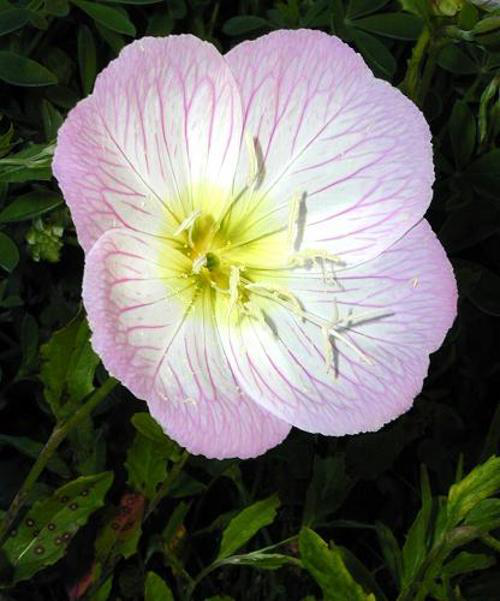

In [9]:
image_loc = 'flowers/test/1/image_06743.jpg'
img = Image.open(image_loc)
img

## When formally defined as an image processor

In [10]:
def process_image(image_path):
    ''' 
    Scales, crops, and normalizes a PIL image for a PyTorch       
    model, returns an Numpy array
    '''
    # Open the image
    
    from PIL import Image
    img = Image.open(image_path)
    
    # Resize the image so the shortest side is 256
    
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))
        
    # Create margins, then cut out the center of the picture
    
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    
    # Scale 0 to 1
    
    img = np.array(img)/255
    
    # Normalize image arrays
    
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    img = (img - mean)/std
    
    # Change order of columns due to PyTorch's expectations
    
    img = img.transpose((2, 0, 1))
    
    return img

In [11]:
img2 = process_image(image_loc);

To check my work, the function below converts a PyTorch tensor and displays it in the notebook. If my `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [12]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

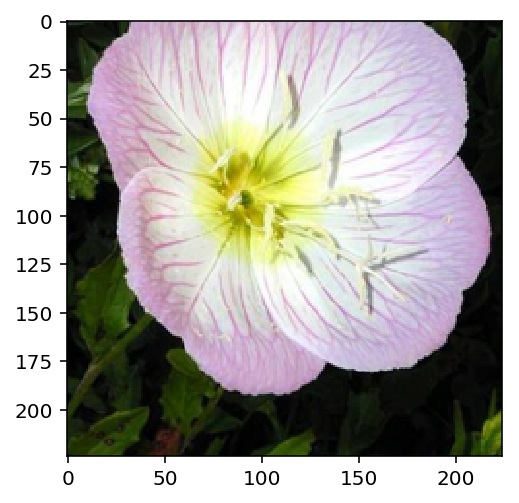

In [13]:
imshow(img2);

## Class Prediction

Once I can get images in the correct format, it's time to write a function for making predictions with my model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. I'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. I need to convert from these indices to the actual class labels using `class_to_idx` which I added to the model or from an `ImageFolder` I used to load the data ([see here](#Save-the-checkpoint)). I make sure to invert the dictionary so I get a mapping from index to class as well.

This method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

## Define the prediction function

In [14]:
# TODO: Implement the code to predict the class from an image file

def predict(image_path, model, top_num=5):
    # Process image as before
    img = process_image(image_path)
    
    # Convert numpy array to tensor
    image_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Add batch of size 1 to image
    model_input = image_tensor.unsqueeze(0)
    
    # Probabilities from model
    probs = torch.exp(model.forward(model_input))
    
    # List top probabilities
    top_probs, top_labs = probs.topk(top_num)
    top_probs = top_probs.detach().numpy().tolist()[0] 
    top_labs = top_labs.detach().numpy().tolist()[0]
    
    # Convert indices to classes
    idx_to_class = {val: key for key, val in    
                                      model.class_to_idx.items()}
    top_labels = [idx_to_class[lab] for lab in top_labs]
    top_flowers = [cat_to_name[idx_to_class[lab]] for lab in top_labs]
    return top_probs, top_labels, top_flowers

## Predict

In [15]:
image_loc = 'flowers/test/10/image_07104.jpg'
top_probs, top_labels, top_flowers = predict(image_loc, model, 5)

print(top_probs)
print(top_labels)
print(top_flowers)

[0.7536899447441101, 0.24630367755889893, 5.245008651399985e-06, 6.044350584488711e-07, 5.243535952104139e-07]
['10', '14', '29', '35', '12']
['globe thistle', 'spear thistle', 'artichoke', 'alpine sea holly', "colt's foot"]


## Sanity Checking

Now that I can use a trained model for predictions, I check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. I use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

I can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (loaded earlier in the notebook). To show a PyTorch tensor as an image, I use the `imshow` function defined above.

In [16]:
# TODO: Display an image along with the top 5 classes

def plot_solution(image_path, model):
    # Create plot
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)
    # Set up title
    flower_num = image_path.split('/')[2]
    title_ = cat_to_name[flower_num]
    # Plot flower image
    img = process_image(image_path)
    imshow(img, ax, title = title_);
    # Make predictions
    probs, labs, flowers = predict(image_path, model) 
    # Plot seaborn bar chart
    plt.subplot(2,1,2)
    seaborn.barplot(x=probs, y=flowers, color=seaborn.color_palette()[0]);
    plt.show()

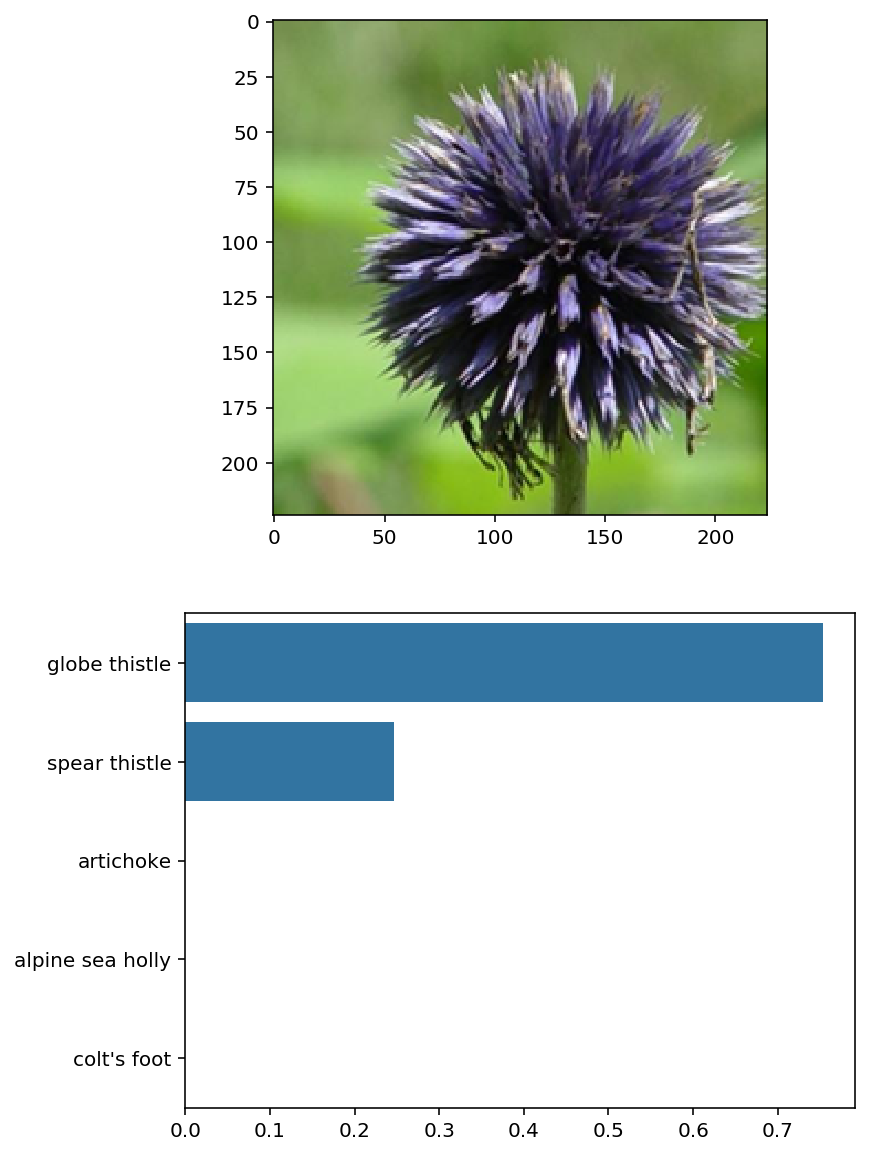

In [17]:
image_loc = 'flowers/test/10/image_07104.jpg'
plot_solution(image_loc, model)

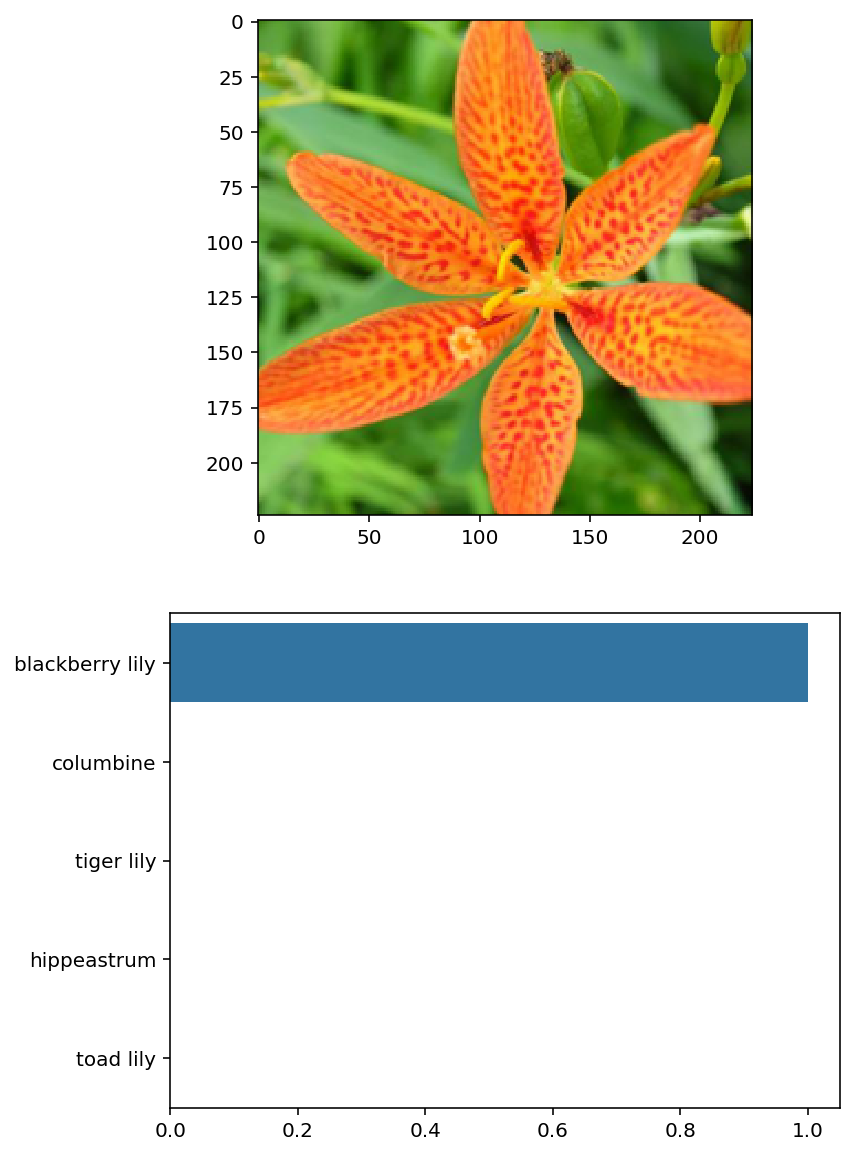

In [18]:
image_loc = 'flowers/test/102/image_08004.jpg'
plot_solution(image_loc, model)

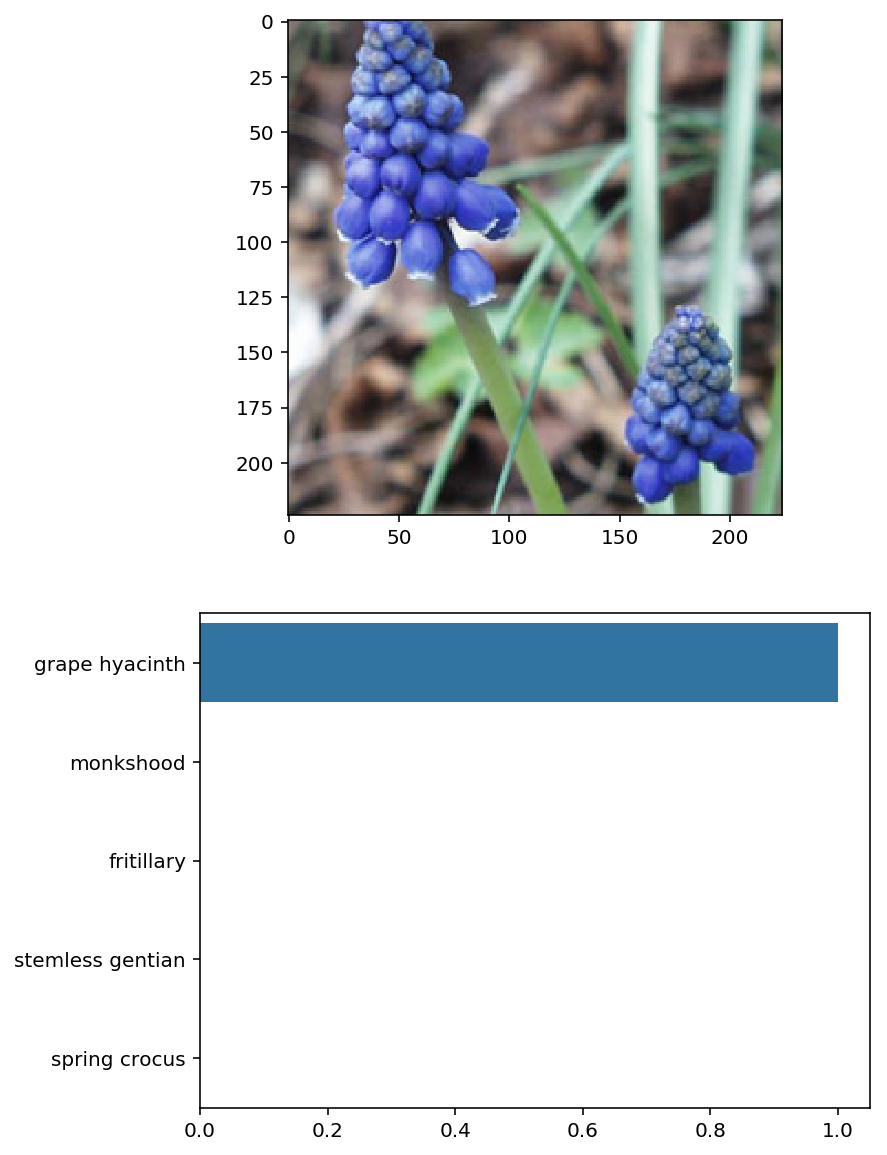

In [19]:
image_loc = 'flowers/test/25/image_06580.jpg'
plot_solution(image_loc, model)